In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## 1.

In [4]:
def image_sharpness(frame):
    F = np.fft.fft2(frame)

    Fc = np.fft.fftshift(F)

    AF = np.abs(Fc)

    M = np.max(AF)

    Th = np.sum(AF > (M / 1000))

    return Th / (frame.shape[0] * frame.shape[1])

### 1.1

In [5]:
video_path = './data/focus_video.mov'
cap = cv2.VideoCapture(video_path)
fm_scores = []

while cap.isOpened():
    ret, frame = cap.read()

    if ret:
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        fm_scores.append(image_sharpness(gray_frame))
    else:
        break

cap.release()

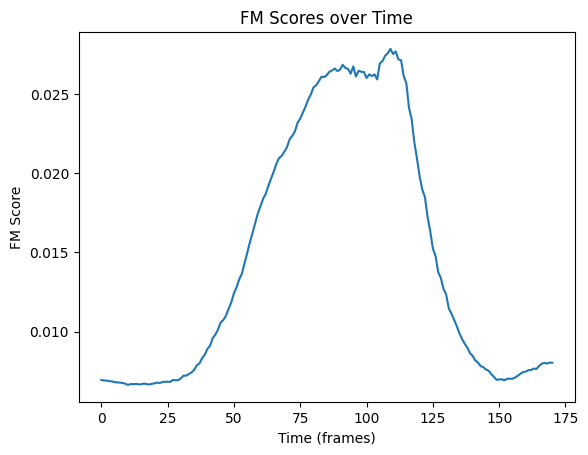

In [6]:
plt.plot(fm_scores)
plt.xlabel('Time (frames)')
plt.ylabel('FM Score')
plt.title('FM Scores over Time')
plt.show()

In [7]:
def plot_img(img):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 1, 1)
    plt.imshow(img)
    plt.axis('off')

    plt.show()

### 1.2

In [38]:
def roi_grid(frame, grid_size=(8, 8), roi_size=20, color=(0, 0, 255)):
    output_image = frame.copy()
    spacing = 20

    total_grid_width = grid_size[1] * roi_size + (grid_size[1] - 1) * spacing
    total_grid_height = grid_size[0] * roi_size + (grid_size[0] - 1) * spacing

    img_height, img_width = frame.shape[:2]
    start_x = (img_width - total_grid_width) // 2
    start_y = (img_height - total_grid_height) // 2

    rois = []

    for row in range(grid_size[0]):
        for col in range(grid_size[1]):
            x = start_x + col * (roi_size + spacing)
            y = start_y + row * (roi_size + spacing)

            top_left = (x, y)
            bottom_right = (x + roi_size, y + roi_size)

            rois.append(frame[y:y + roi_size, x:x + roi_size])
            
            cv2.rectangle(output_image, top_left, bottom_right, color, 2)

    return rois, output_image

In [39]:
def get_video_writer(output_path, capture):
    width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(capture.get(cv2.CAP_PROP_FPS))
    codec = cv2.VideoWriter_fourcc(*'avc1')
    return cv2.VideoWriter(output_path, codec, fps, (width, height))

In [54]:
video_path = './data/focus_video.mov'
output_video_path = "./data/output_single_roi_video.mov"

cap = cv2.VideoCapture(video_path)
fm_scores = []

out = get_video_writer(output_video_path, cap)
focus_threshold = 2

while cap.isOpened():
    ret, frame = cap.read()

    if ret:
        # Single ROI, 6.25 % of image size ((120 * 120) / (360 * 640))
        rois, _ = roi_grid(frame, (1,1), 120, 2)
        score = image_sharpness(rois[0]) 
        fm_scores.append(score)
        _, colored_rois = roi_grid(frame, (1,1), 120, (0, 255, 0) if score >= focus_threshold else (0, 0, 255))
        out.write(colored_rois)

    else:
        break

cap.release()
out.release()
cv2.destroyAllWindows()

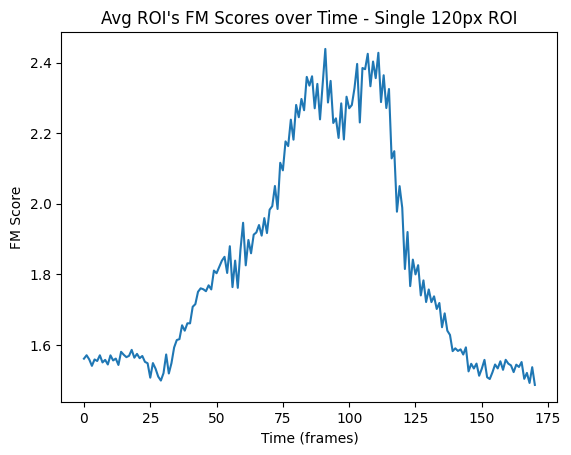

In [42]:
plt.plot(fm_scores)
plt.xlabel('Time (frames)')
plt.ylabel('FM Score')
plt.title('Avg ROI\'s FM Scores over Time - Single 120px ROI')
plt.show()

In [82]:
def score_grid(grid, size, threshold, output):
    video_path = 'data/focus_video.mov'
    
    cap = cv2.VideoCapture(video_path)
    fm_scores = []
    
    out = get_video_writer(output, cap)
    
    while cap.isOpened():
        ret, frame = cap.read()
    
        if ret:
            # Default grid, 8x8 20px squares
            rois, _ = roi_grid(frame, grid, size)
            score = np.mean([image_sharpness(roi) for roi in rois])
            fm_scores.append(score)
            _, colored_rois = roi_grid(frame, grid, size, (0, 255, 0) if score >= threshold else (0, 0, 255))
            out.write(colored_rois)
    
        else:
            break
    
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    
    plt.plot(fm_scores)
    plt.xlabel('Time (frames)')
    plt.ylabel('FM Score')
    plt.title(f'Avg ROI\'s FM Scores over Time - {grid} grid')
    plt.show()

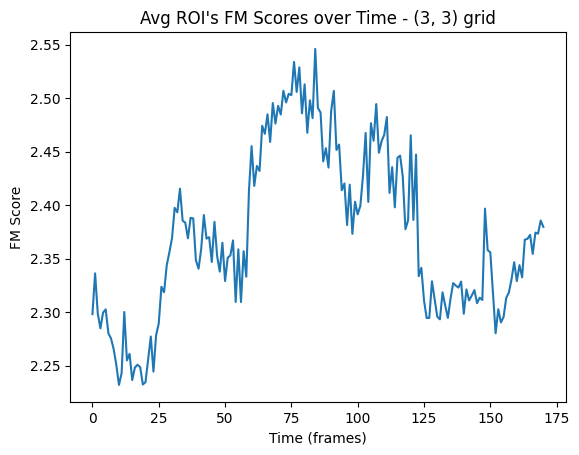

In [103]:
score_grid((3,3), 40, 2.4, "./data/output_3x3_roi_video.mov")

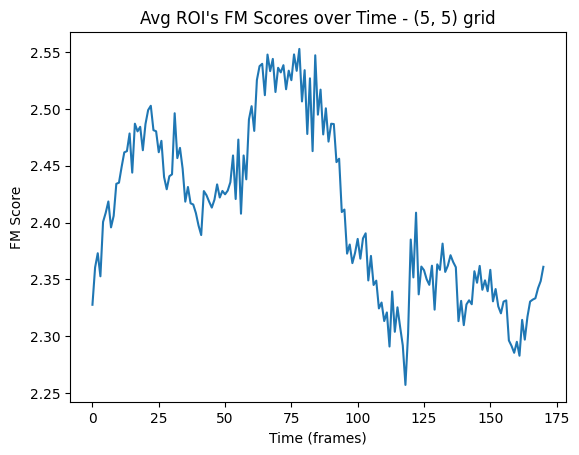

In [100]:
score_grid((6,6), 30, 2.4, "./data/output_6x6_roi_video.mov")

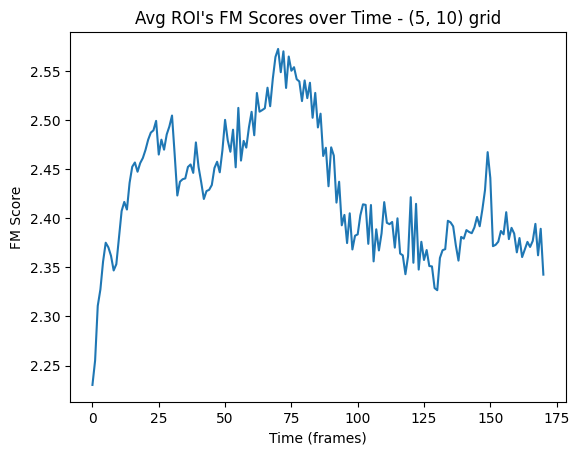

In [101]:
score_grid((5,10), 20, 2.6,"./data/output_10x5_roi_video.mov")

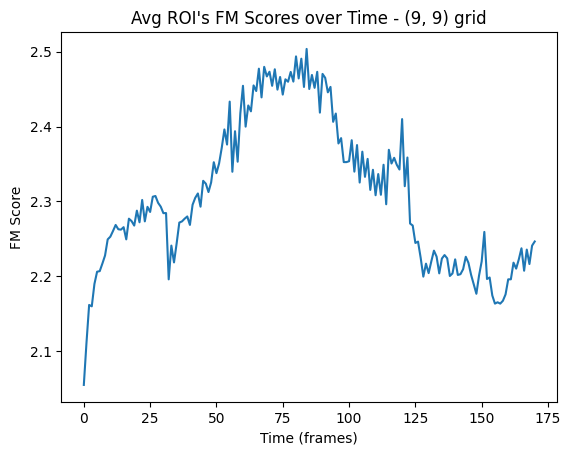

In [102]:
score_grid((9,9), 20, 2.3, "./data/output_9x9_roi_video.mov")